In [1]:

import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
import os

In [2]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:

IMG_SIZE = (256, 256)
VALID_SPLIT = 0.3
BATCH_SIZE = 16
SEED = 42
PATH = "D:\CNN\DTAA\Food Classification"

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    PATH,
    validation_split=VALID_SPLIT,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    PATH,
    validation_split=VALID_SPLIT,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

Found 6259 files belonging to 20 classes.
Using 4382 files for training.
Found 6259 files belonging to 20 classes.
Using 1877 files for validation.


In [4]:
class_names = train_ds.class_names
for i, class_name in enumerate(class_names):
    print(f"Index {i}: {class_name}")

classes = train_ds.class_names

Index 0: burger
Index 1: butter_naan
Index 2: chai
Index 3: chapati
Index 4: chole_bhature
Index 5: dal_makhani
Index 6: dhokla
Index 7: fried_rice
Index 8: idli
Index 9: jalebi
Index 10: kaathi_rolls
Index 11: kadai_paneer
Index 12: kulfi
Index 13: masala_dosa
Index 14: momos
Index 15: paani_puri
Index 16: pakode
Index 17: pav_bhaji
Index 18: pizza
Index 19: samosa


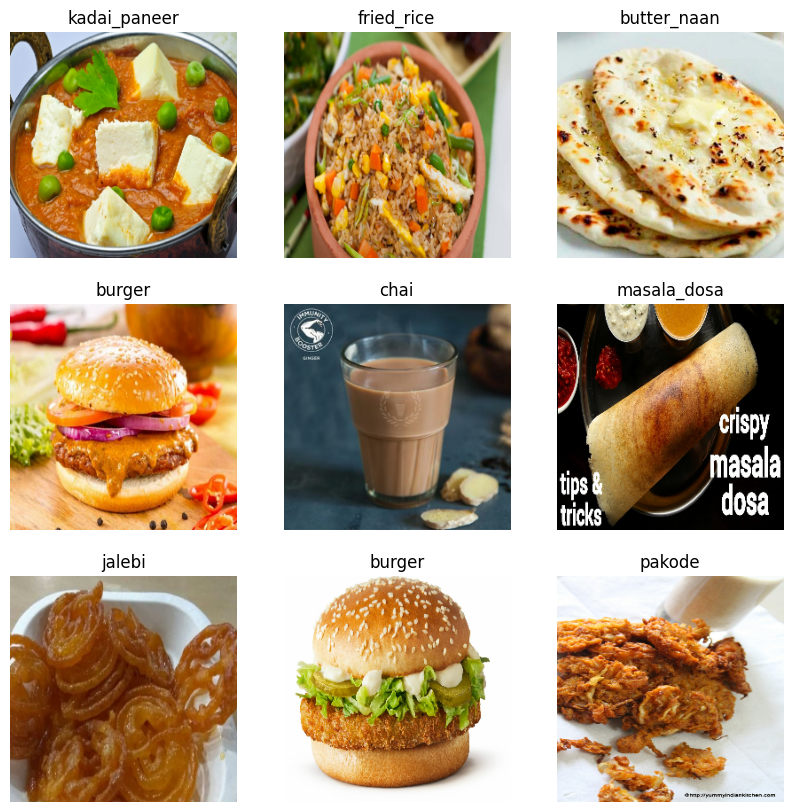

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classes[np.argmax(labels[i])])
        plt.axis("off")

In [6]:

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomBrightness(0.1)
])

augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

In [7]:
augmented_train_ds = augmented_train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [8]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)

    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(64, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  

    for size in [128, 256, 512, 512]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  
        previous_block_activation = x  

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    
    return keras.Model(inputs, outputs)

print(IMG_SIZE + (3,))
model = make_model(input_shape=IMG_SIZE + (3,), num_classes=len(classes))

(256, 256, 3)


In [9]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 256, 256,  │          0 │ input_layer_1[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 256, 256,  │          0 │ sequential[0][0]  │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ rescaling[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d    │ (None, 128, 128,  │      8,896 │ activation_2[0][… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ separable_conv2d… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1  │ (None, 128, 128,  │     17,664 │ activation_3[0][… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ separable_conv2d… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │      8,320 │ activation_1[0][

 Total params: 2,105,108 (8.03 MB)

 Trainable params: 2,097,172 (8.00 MB)

 Non-trainable params: 7,936 (31.00 KB)

In [10]:
file_path = "D:\CNN\DTAA\Food Classification"
PATH = "D:\CNN\DTAA\Food Classification"


In [ ]:
ok = True

if ok:
    EPOCHS = 50
    CALLBACK = [
    keras.callbacks.ModelCheckpoint(
        filepath='model.{epoch:02d}-{val_loss:.2f}.keras',
        save_best_only=True  
    ),
    keras.callbacks.EarlyStopping(patience=5),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=3,min_lr=1e-6,verbose=1)
    ]

    
    model.compile(
        optimizer='adam',
        loss="categorical_crossentropy",
        metrics=["categorical_accuracy"],
    )
    
    history = model.fit(
        augmented_train_ds,
        epochs=EPOCHS,
        callbacks=CALLBACK,
        validation_data=val_ds,
    )
    print("Training Completed")
    
else:
    model = keras.models.load_model('D:\CNN\model.43-0.73.keras.keras')

Epoch 1/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 931s 3s/step - categorical_accuracy: 0.1436 - loss: 2.9804 - val_categorical_accuracy: 0.0671 - val_loss: 4.5525 - learning_rate: 0.0010
Epoch 2/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 898s 3s/step - categorical_accuracy: 0.2562 - loss: 2.4285 - val_categorical_accuracy: 0.0895 - val_loss: 3.4777 - learning_rate: 0.0010
Epoch 3/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 898s 3s/step - categorical_accuracy: 0.3335 - loss: 2.1959 - val_categorical_accuracy: 0.1518 - val_loss: 3.6581 - learning_rate: 0.0010
Epoch 4/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 948s 3s/step - categorical_accuracy: 0.3773 - loss: 2.0519 - val_categorical_accuracy: 0.1700 - val_loss: 3.3610 - learning_rate: 0.0010
Epoch 5/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 958s 3s/step - categorical_accuracy: 0.4110 - loss: 1.9144 - val_categorical_accuracy: 0.2690 - val_loss: 2.8408 - learning_rate: 0.0010
Epoch 6/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 897s 3s/step - categorical_accuracy: 0.4660 - loss: 1.7347 - val_categorica

In [12]:
print(history.history.keys())

dict_keys(['categorical_accuracy', 'loss', 'val_categorical_accuracy', 'val_loss', 'learning_rate'])


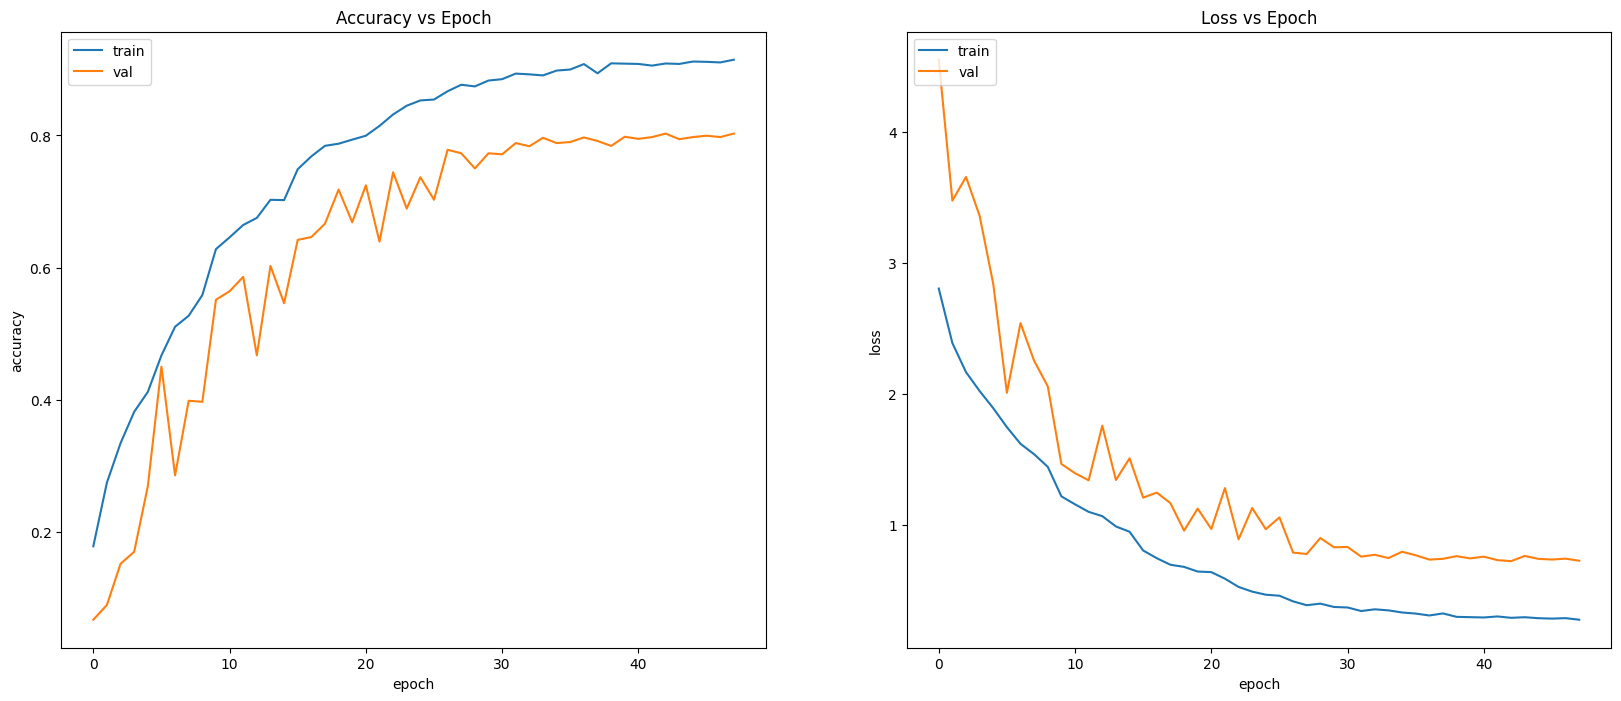

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

ax[0].plot(history.history['categorical_accuracy'])
ax[0].plot(history.history['val_categorical_accuracy'])
ax[0].set_title('Accuracy vs Epoch')
ax[0].set(xlabel='epoch', ylabel='accuracy')
ax[0].legend(['train', 'val'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Loss vs Epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
ax[1].legend(['train', 'val'], loc='upper left')

plt.show()

In [ ]:
imgs = [
    "D:\CNN\Input\chapati.jpg",
    "D:\CNN\Input\jalebi.jpg",
    "D:\CNN\Input\idli.jpg",
    "D:/CNN/Input/burger.jpg"
]
model = keras.models.load_model('D:\CNN\model.43-0.73.keras')

for img in imgs:
    try:
        raw_img = keras.preprocessing.image.load_img(img, target_size=IMG_SIZE)
    except:
        continue
    
    img_array = keras.preprocessing.image.img_to_array(raw_img)
    img_array = tf.expand_dims(img_array, 0)  
    predictions = model.predict(img_array)
    series      = pd.Series(predictions[0], index=classes)
    proba      = np.max(predictions)
    pred_class = classes[np.argmax(predictions)]
    
    fig, ax = plt.subplots(1, 2, figsize=(24, 4))
    
    ax[0].imshow(raw_img)
    ax[0].title.set_text(f"This image may be {pred_class} at {round(proba * 100,2)}%")
    
    series.plot(kind='bar', ax=ax[1], color='green')
    ax[1].title.set_text("Probabilities")
    ax[1].tick_params(labelrotation=75)
    
    plt.show()